In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler

# Processamento


In [36]:
def load_data(filepath):
    return pd.read_csv(filepath)

In [41]:
def excluir_colunas_vazias(df, limite=80):
    
    percentual_vazio = df.isnull().mean() * 100
    colunas_a_remover = percentual_vazio[percentual_vazio > limite].index
    df_sem_colunas_vazias = df.drop(columns=colunas_a_remover)
    
    if len(colunas_a_remover) > 0:
        print(f"Colunas removidas (com mais de {limite}% de dados vazios):")
        print(colunas_a_remover)
    
    return df_sem_colunas_vazias

In [55]:
def preencher_com_media(df):
   
    for coluna in df.columns:
        if pd.api.types.is_numeric_dtype(df[coluna]):
            media_coluna = df[coluna].mean()
            df[coluna].fillna(media_coluna, inplace=True)
            print(f"Preenchendo a coluna '{coluna}' com a média ({media_coluna})")
    return df

In [37]:
def feature_selection_nn(df, n_features=15):

    df = df.dropna().copy()
    X = df.select_dtypes(include=[np.number])  #
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1)
    selector = selector.fit(X_scaled, np.ones(X_scaled.shape[0]))  
    selected_features = X.columns[selector.support_].tolist()
    
    print("Atributos selecionados:", selected_features)
    
    return selected_features


# Usando as funções

In [56]:
if __name__ == "__main__": 
    import os
    filepath = r'C:\Users\annab\OneDrive\Documentos\GitHub\Colabs\RECPAD\Processamento\df_processed'
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"O arquivo especificado não foi encontrado: {filepath}")
    
    df = load_data(filepath)

    # Excluir colunas com mais de 80% de valores ausentes
    df_processed = excluir_colunas_vazias(df, limite=80)

    # Seleção de atributos
    selected_features = feature_selection_nn(df_processed, n_features=16)

    # Criar o DataFrame com as colunas selecionadas
    df_selected = df_processed[selected_features]

    # Preencher valores ausentes com a média
    df_final = preencher_com_media(df_selected)

    # Exibir os atributos selecionados
    print("Atributos selecionados:", selected_features)
    print(df_final.head())

Colunas removidas (com mais de 80% de dados vazios):
Index(['CODANOMAL', 'IDADEPAI'], dtype='object')
Atributos selecionados: ['ESCMAE2010', 'SERIESCMAE', 'DTNASCMAE', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR', 'QTDPARTCES', 'DTULTMENST', 'CONSPRENAT', 'MESPRENAT', 'ESCMAEAGR1', 'STDNEPIDEM', 'STDNNOVA', 'CODPAISRES', 'PARIDADE', 'CLASSE']
Preenchendo a coluna 'ESCMAE2010' com a média (2.908573634072315)
Preenchendo a coluna 'SERIESCMAE' com a média (4.069756606303585)
Preenchendo a coluna 'DTNASCMAE' com a média (15694128.114968793)
Preenchendo a coluna 'RACACORMAE' com a média (3.3158497957004864)
Preenchendo a coluna 'QTDGESTANT' com a média (1.2429323587590126)
Preenchendo a coluna 'QTDPARTNOR' com a média (0.7146820561312524)
Preenchendo a coluna 'QTDPARTCES' com a média (0.32442993819453114)
Preenchendo a coluna 'DTULTMENST' com a média (15664020.507253477)
Preenchendo a coluna 'CONSPRENAT' com a média (8.579044997957393)
Preenchendo a coluna 'MESPRENAT' com a média (4.64077222047

C:\Users\annab\AppData\Local\Temp\ipykernel_36060\2006828257.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[coluna].fillna(media_coluna, inplace=True)
C:\Users\annab\AppData\Local\Temp\ipykernel_36060\2006828257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[coluna].fillna(media_coluna, inplace=True)


In [60]:
df_majority = df_final[df_final['CLASSE'] == 0]
df_minority = df_final[df_final['CLASSE'] == 1]

df_minority_test = df_minority.sample(frac=0.3, random_state=42)
df_majority_test = df_majority.sample(n=df_minority_test.shape[0], random_state=42)
test_df = pd.concat([df_majority_test, df_minority_test])

df_majority_train = df_majority.drop(df_majority_test.index)
df_minority_train = df_minority.drop(df_minority_test.index)
train_df = pd.concat([df_majority_train, df_minority_train])

In [61]:
test_df['CLASSE'].value_counts()

CLASSE
0    17096
1    17096
Name: count, dtype: int64

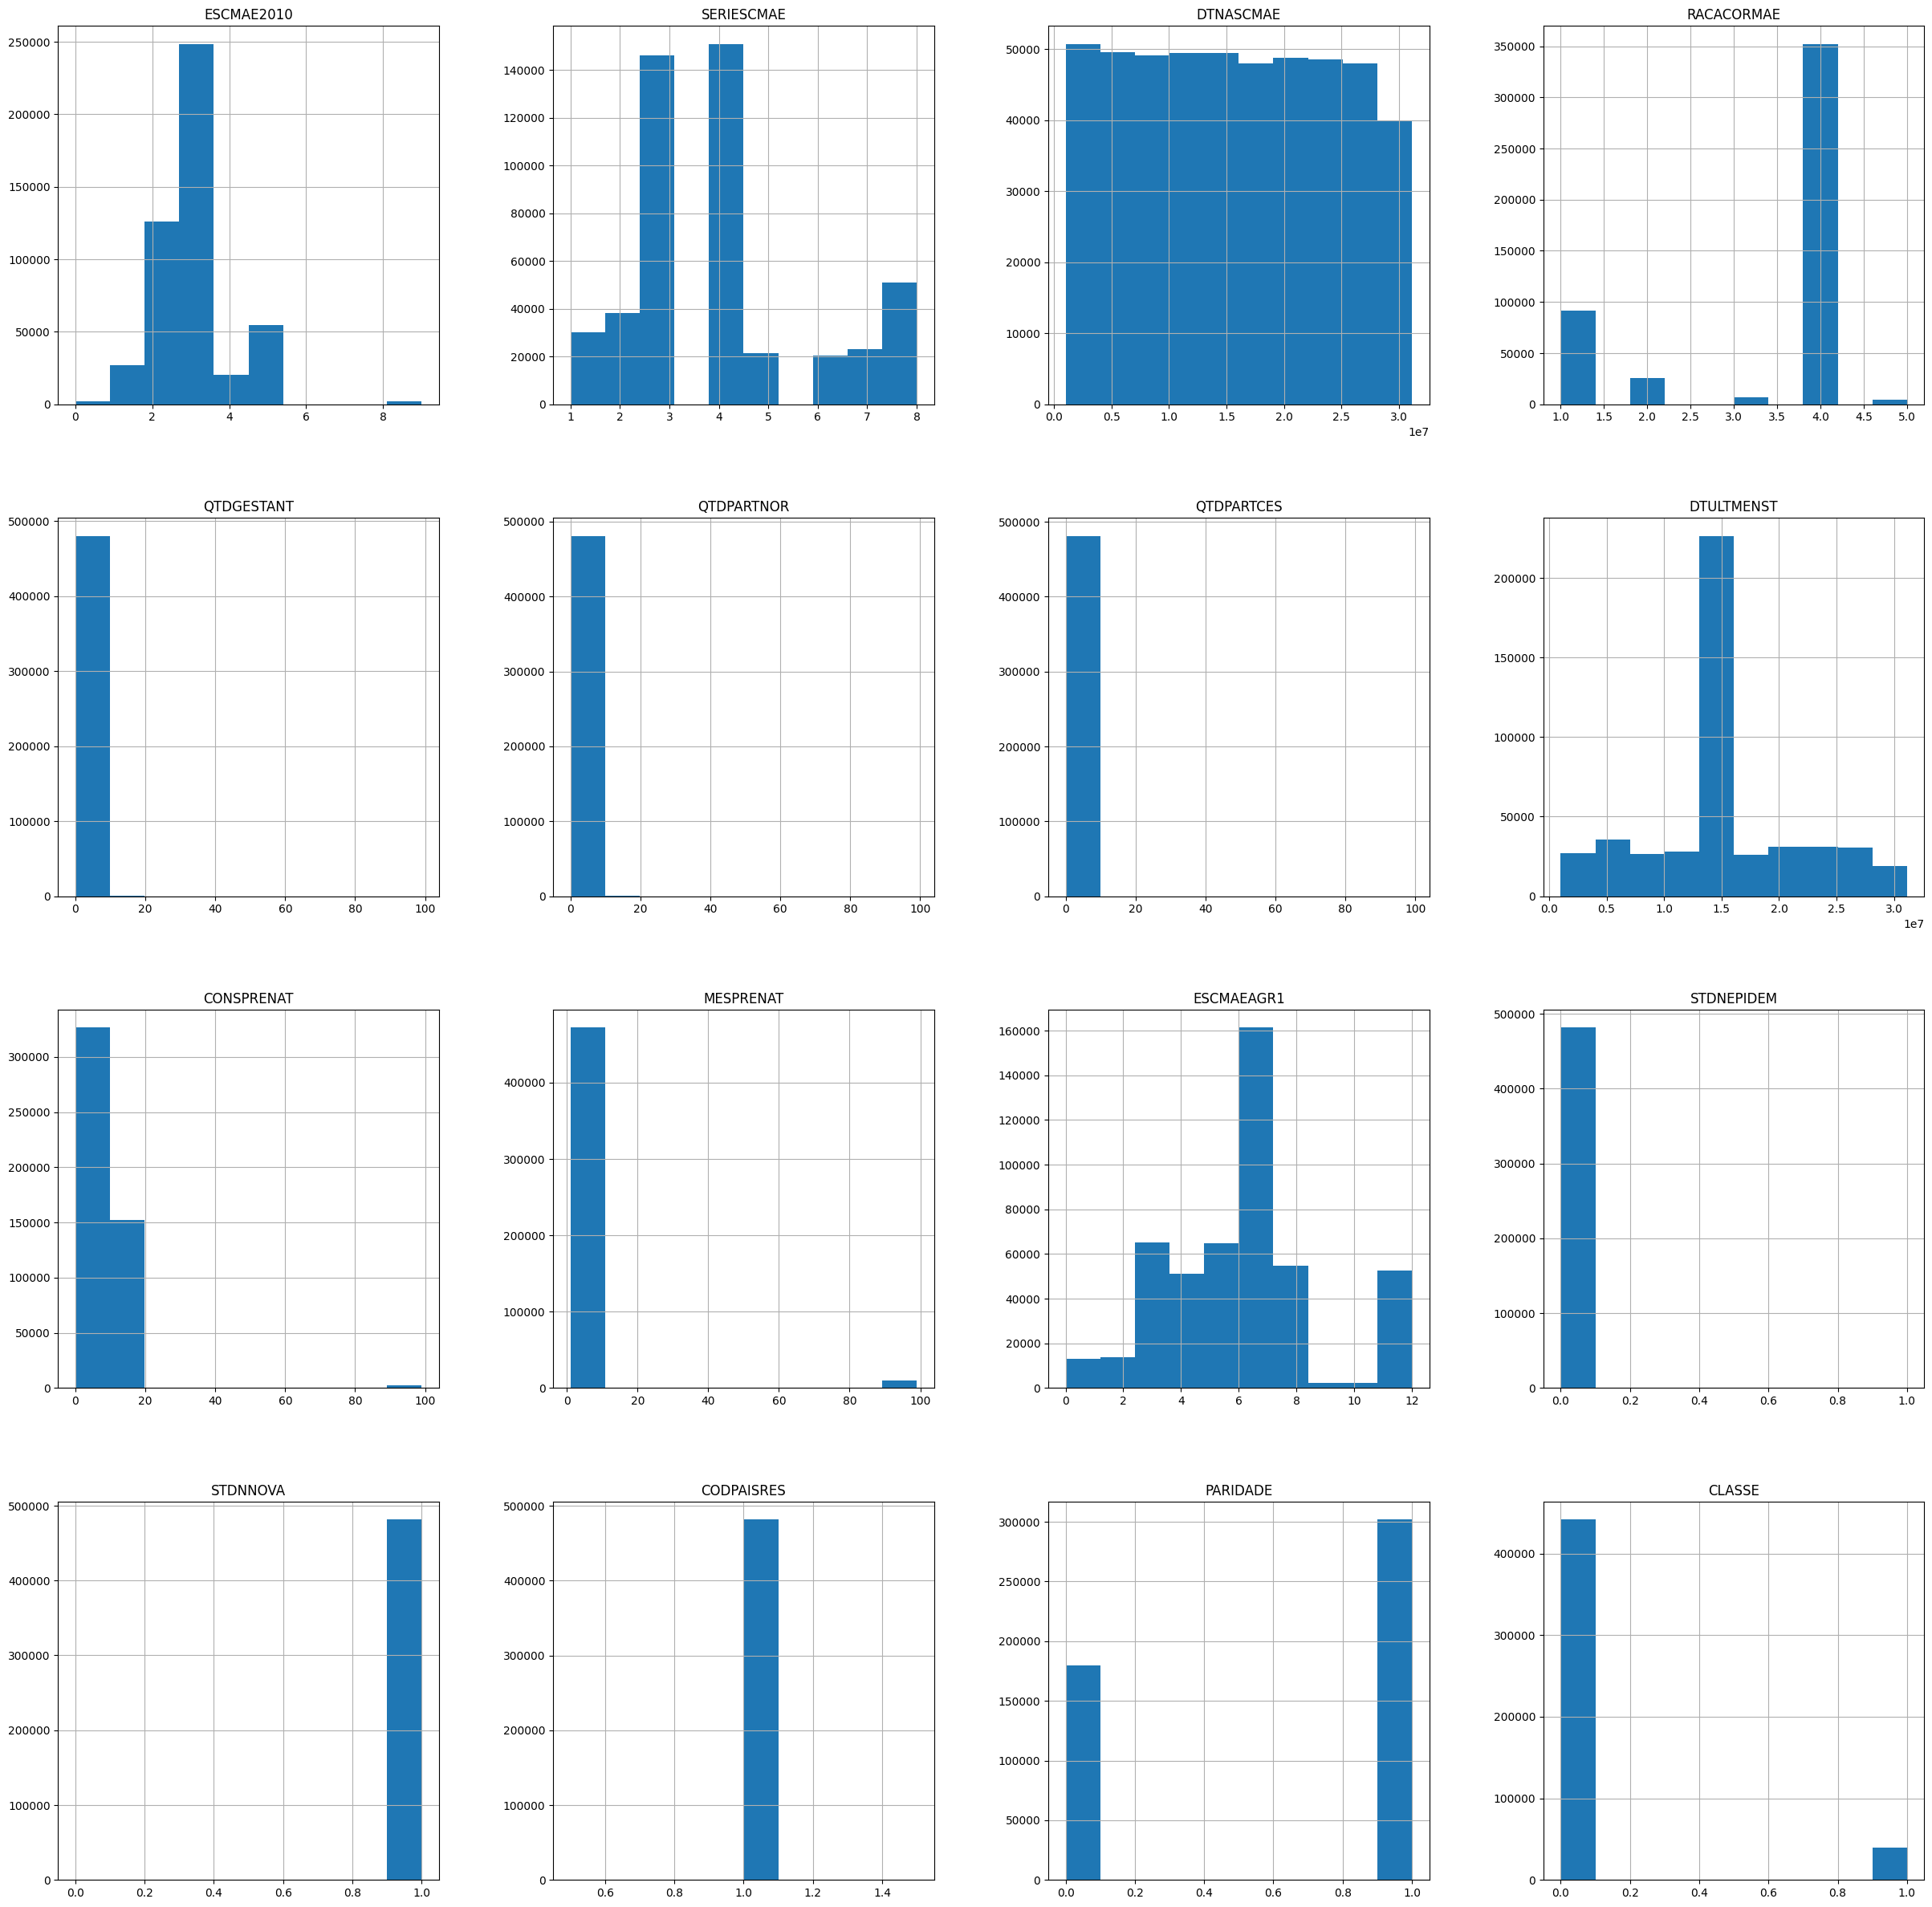

In [62]:
train_df.hist(figsize=(30,30))
plt.show()

In [63]:
train_df['CLASSE'].value_counts()

CLASSE
0    441561
1     39891
Name: count, dtype: int64

In [64]:
X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Treinamento dos modelos

# Decision Tree

Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.62      0.65      0.64     17096
           1       0.64      0.60      0.62     17096

    accuracy                           0.63     34192
   macro avg       0.63      0.63      0.63     34192
weighted avg       0.63      0.63      0.63     34192



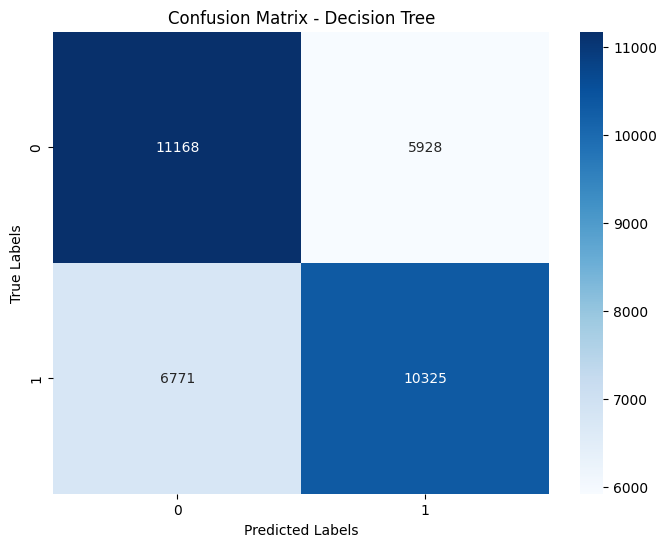

In [246]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

X_test = test_df.drop(columns=['CLASSE'])
y_test = test_df['CLASSE']

param_grid_dt = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 10]
  }

dt_model = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_dt.fit(X_train_balanced, y_train_balanced)
best_params_dt = grid_search_dt.best_params_
print("Melhores parâmetros encontrados:", best_params_dt)

best_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
best_dt_model.fit(X_train_balanced, y_train_balanced)

y_pred_dt = best_dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap="Blues",
                xticklabels=best_dt_model.classes_,
                yticklabels=best_dt_model.classes_,
                cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

Melhor Threshold Calculado: 0.3427
Melhor F1-Score Correspondente: 0.6760


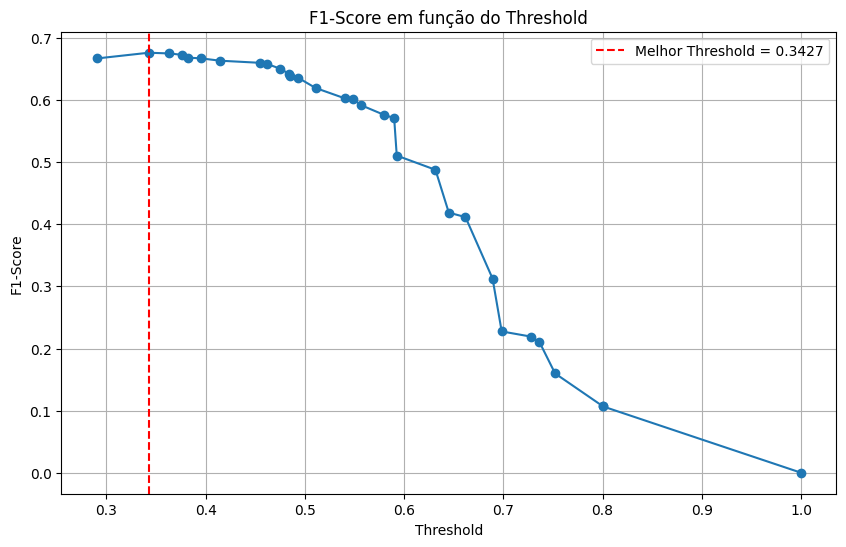

In [247]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_prob_dt))

f1_scores = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_prob_dt >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold_index = np.argmax(f1_scores)
best_threshold = unique_thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor F1-Score Correspondente: {best_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, f1_scores, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()


In [250]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]

threshold = 0.34
y_pred_threshold = (y_prob_dt >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

thresholds_f1 = np.sort(np.unique(y_prob_dt))
f1_scores = []

for t in thresholds_f1:
    y_pred_dt = (y_prob_dt >= t).astype(int)
    f1 = f1_score(y_test, y_pred_dt)
    f1_scores.append(f1)

Threshold Utilizado: 0.3400
Acurácia: 0.5685
Precisão (PPV): 0.5412
Recall (Sensibilidade): 0.9002
F1-Score: 0.6760
Especificidade: 0.2367
PPV: 0.5412
NPV: 0.7035
FPR (Taxa de Falsos Positivos): 0.7633
Classificados Corretamente: 19437 de 34192


# Random Forest

Melhores parâmetros encontrados: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     17096
           1       1.00      0.00      0.00     17096

    accuracy                           0.50     34192
   macro avg       0.75      0.50      0.33     34192
weighted avg       0.75      0.50      0.33     34192



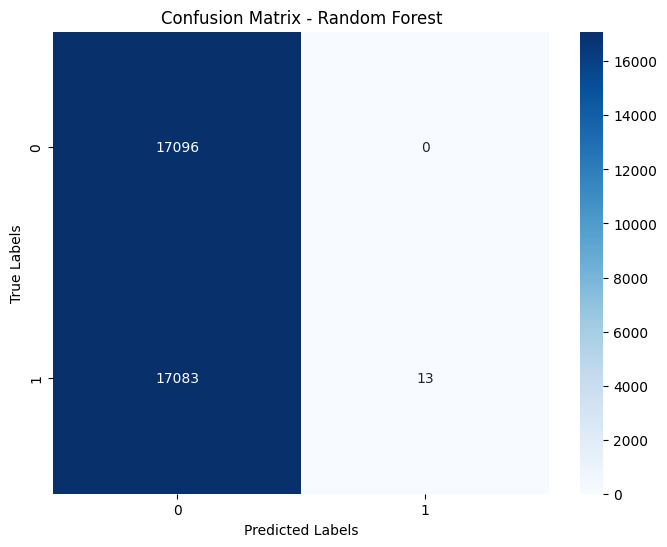

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

X_test = test_df.drop(columns=['CLASSE'])
y_test = test_df['CLASSE']

param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Melhores parâmetros encontrados:", best_params_rf)

best_rf_model = RandomForestClassifier(random_state=42, **best_params_rf)
best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap="Blues",
            xticklabels=best_rf_model.classes_,
            yticklabels=best_rf_model.classes_,
            cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Melhor Threshold Calculado: 0.0437
Melhor F1-Score Correspondente: 0.6838


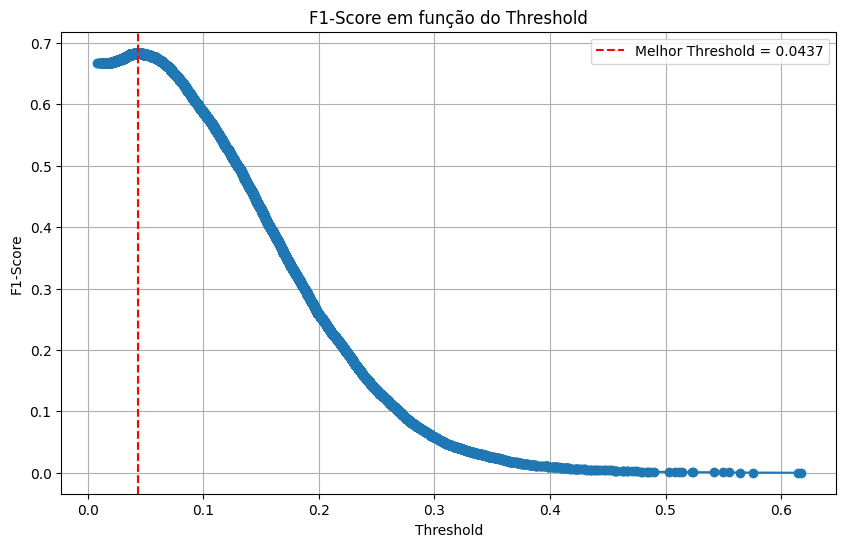

In [251]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

y_pred_rf = best_rf_model.predict_proba(X_test)[:, 1]
unique_thresholds = np.sort(np.unique(y_pred_rf))

f1_scores = []

for threshold in unique_thresholds:
    y_pred_threshold = (y_pred_rf >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold_index = np.argmax(f1_scores)
best_threshold = unique_thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Melhor Threshold Calculado: {best_threshold:.4f}")
print(f"Melhor F1-Score Correspondente: {best_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(unique_thresholds, f1_scores, marker='o')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Melhor Threshold = {best_threshold:.4f}")
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score em função do Threshold')
plt.legend()
plt.grid()
plt.show()


In [255]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

y_pred_rf = best_rf_model.predict_proba(X_test)[:, 1]

threshold = 0.07
y_pred_threshold = (y_pred_rf >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()

accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
correctly_classified = accuracy * len(y_test)

print(f"Threshold Utilizado: {threshold:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão (PPV): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {npv:.4f}")
print(f"FPR (Taxa de Falsos Positivos): {fpr:.4f}")
print(f"Classificados Corretamente: {correctly_classified:.0f} de {len(y_test)}")

thresholds_f1 = np.sort(np.unique(y_prob_dt))
f1_scores = []

for t in thresholds_f1:
    y_pred_dt = (y_prob_dt >= t).astype(int)
    f1 = f1_score(y_test, y_pred_dt)
    f1_scores.append(f1)

Threshold Utilizado: 0.0700
Acurácia: 0.6356
Precisão (PPV): 0.6187
Recall (Sensibilidade): 0.7071
F1-Score: 0.6599
Especificidade: 0.5642
PPV: 0.6187
NPV: 0.6583
FPR (Taxa de Falsos Positivos): 0.4358
Classificados Corretamente: 21734 de 34192


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Separação dos dados
X_train = train_df.drop(columns=['CLASSE'])
y_train = train_df['CLASSE']
X_test = test_df.drop(columns=['CLASSE'])
y_test = test_df['CLASSE']

# Balanceamento com RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

# Definição do modelo SVM
svm = SVC()

# Definição dos hiperparâmetros para o GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],           # Parâmetro de penalização
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Parâmetro do núcleo RBF
    'kernel': ['linear', 'rbf', 'poly']  # Tipos de núcleos a serem testados
}

# Realizando o GridSearch com 5 folds de validação cruzada
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Treinando o modelo
grid_search.fit(X_train_balanced, y_train_balanced)

# Exibindo os melhores parâmetros encontrados
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

# Avaliar o melhor modelo nos dados de teste
best_svm = grid_search.best_estimator_

# Predições no conjunto de teste
y_pred = best_svm.predict(X_test)

# Avaliação do modelo
print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
